# Generate feature vectors for defect classification

This notebook generates feature vectors to be used for clustering local patterns in Rayleigh-Benard Convection. We use a variant of HOGS (histogram of gradients) based on the orientation field of the temperature field of Rayleigh-Benard Convection in addition to categorical variables describing the topological and persistent homology defect counts.

In [82]:
import numpy as np
import scipy
from scipy.cluster import hierarchy as hc
import pandas as pd
from skimage import morphology
from scipy import misc
from matplotlib import pyplot as plt
import math, time
from skimage import measure

%matplotlib inline  

## Set up local environment variables

In [88]:
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2016_11_01_superfast/g21flow'
centerx = 210 # Center-x of circular crop
centery = 210 # Center-y of circular crop
crop_radius = 175 # Radius of circular crop
roll_width = 20 # Width of a single roll
sOrientation = 'orientation_field_0_5/%06d.bmp'
sOrientation_smooth = 'orientation_field_2/%06d.bmp'
sPatternData = 'pattern_data/%06d_matches.csv'
sSingularPoints = 'singular_points_0_5/%06d.txt'
sSingularPoints_smooth = 'singular_points_2/%06d.txt'

## Set up variables for generating the feature vectors

In [84]:
radius = roll_width

## Utility functions

In [85]:
def loadData(idx):
    # Get orientation field
    of = misc.imread(sDir + "/" + (sOrientation % idx))
    
    # Persistent homology defects: pinch=1, h1=2
    ph_features = pd.read_csv(sDir + "/" + (sPatternData % idx))

    # Generate persistent homology defect matrix
    ph_pinches = ph_features.loc[(ph_features['match_type']=='pinch_upper') | (ph_features['match_type']=='pinch_lower')][['center_x','center_y']]
    ph_pinches = ph_pinches.astype(np.int)

    ph_h1 = ph_features.loc[(ph_features['match_type']=='ring_other') | (ph_features['match_type']=='ring_upper') | (ph_features['match_type']=='ring_lower') | (ph_features['match_type']=='plume_other') | (ph_features['match_type']=='plume_upper') | (ph_features['match_type']=='plume_lower')][['center_x','center_y']]
    ph_h1 = ph_h1.astype(np.int)

    ph_defects = np.zeros(of.shape)
    ph_defects[ph_pinches['center_y'], ph_pinches['center_x']] = 1
    ph_defects[ph_h1['center_y'], ph_h1['center_x']] = 2

    # Topological defects
    td = pd.read_csv(sDir + "/" + (sSingularPoints % idx), sep=' ', names=['x', 'y', 'type'])

    # Convert to matrix form
    td_defects = np.histogram2d(td['x'], td['y'], bins=[of.shape[0],of.shape[1]], weights=td['type'])[0]
    
    return (of, ph_defects, td_defects)


In [86]:
def getFeatureVector(orientationfield, topological_defects, ph_defects, x, y, radius):
    """
    Takes in a single local patch from the orientation field and generates a feature from it.
    (0,255) = histogram of orientations
    (256,259) = counts of topological defects: +1,-1,+2,-2
    (260,261) = counts of persistent homology defects: pinch-offs, h1 generators
    """
    # Get circular crop
    crop = np.zeros((radius*2, radius*2))
    crop[radius, radius] = 1
    crop = morphology.binary_dilation(crop, morphology.disk(radius))
    
    # Crop orientation field and get historgram
    cropped_orientation = orientationfield[(y-radius):(y+radius), (x-radius):(x+radius)]
    hist = np.histogram(cropped_orientation[crop], bins=range(256))[0]
    
    # Get max histogram value and re-center at 0 for this value
    maxloc = np.argmax(hist)
    hist_orientations = np.concatenate((hist, hist),axis=0)[maxloc:(maxloc+255)]
        
    # Get topological defects from circular region
    cropped_td = topological_defects[(y-radius):(y+radius), (x-radius):(x+radius)][crop]
    cropped_td = cropped_td[cropped_td <> 0]
    hist_td_defects = np.histogram(cropped_td, bins=[-2,-1,0,1,2,3])[0]
    hist_td_defects = hist_td_defects[[0,1,3,4]]
    
    # Get persistent homology defects in the circular region
    cropped_phd = ph_defects[(y-radius):(y+radius), (x-radius):(x+radius)][crop]
    hist_ph_defects = np.histogram(cropped_phd,bins=[1,2,3])[0]
    
    # Return feature vector
    features = np.concatenate((hist_orientations, hist_td_defects, hist_ph_defects), axis=0)
    return features
    

## Get the feature vectors

In [87]:
for idx in range(1000,1999,50):

    lag = 5

    of1, ph_defects1, td_defects1 = loadData(idx)
    of2, ph_defects2, td_defects2 = loadData(idx+lag)

    allFeatures = []

    # Loop through all topological and p.h. defects and generate feature vectors
    coordsx, coordsy = np.where(td_defects1 <> 0)
    coords = np.column_stack((coordsx, coordsy))
    
    tmp_coordsx, tmp_coordsy = np.where(td_defects2 <> 0)
    tmp_coords = np.column_stack((tmp_coordsx, tmp_coordsy))
    coords = np.concatenate((coords, tmp_coords))
    
    tmp_coordsx, tmp_coordsy = np.where(ph_defects1 <> 0)
    tmp_coords = np.column_stack((tmp_coordsx, tmp_coordsy))
    coords = np.concatenate((coords, tmp_coords))
    
    tmp_coordsx, tmp_coordsy = np.where(ph_defects2 <> 0)
    tmp_coords = np.column_stack((tmp_coordsx, tmp_coordsy))
    coords = np.concatenate((coords, tmp_coords))
    
    tuple_coords = [tuple(row) for row in coords]
    unique_coords = np.unique(tuple_coords)
    
    sorted_idx = np.lexsort(coords.T)
    sorted_data =  coords[sorted_idx,:]
    row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))
    unique_coords = sorted_data[row_mask]
    
    for i in range(unique_coords.shape[0]):
        x = unique_coords[i][0]
        y = unique_coords[i][1]
        if (((x - centerx)**2 + (y - centery)**2) <= crop_radius**2):
            features = np.concatenate(([idx, x, y], getFeatureVector(of1, td_defects1, ph_defects1, x, y, radius), getFeatureVector(of2, td_defects2, ph_defects2, x, y, radius)),axis=0)
            if len(allFeatures) == 0:
                allFeatures = features
            else:
                allFeatures = np.vstack([allFeatures, features])


    # Save feature vectors to file
    np.savetxt(sDir + '/' + ('feature_vectors/%06d_%d.txt' % (idx, lag)),allFeatures,fmt='%d',delimiter=' ')

array([299,  18])

In [91]:
n = 30


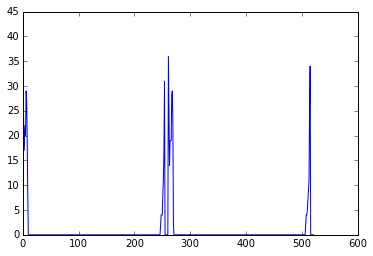

In [92]:
plt.plot(allFeatures[n][3:])

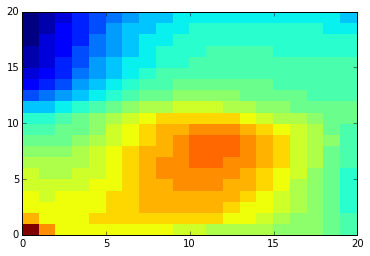

In [93]:
x = allFeatures[n][1]
y = allFeatures[n][2]
plt.pcolor(of1[(y-radius):(y+radius), (x-radius):(x+radius)])

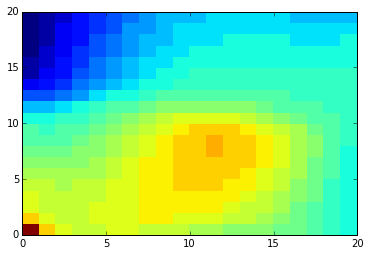

In [94]:

plt.pcolor(of2[(y-radius):(y+radius), (x-radius):(x+radius)])